In [2]:
import numpy as np
import os
import glob
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imread
import tensorflow as tf
from tensorflow import data as tfdata
from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import img_to_array, load_img

In [3]:
sess = tf.Session()
K.set_session(sess)
sess = None

In [113]:
#PATH_TRAIN_RAW_IMG = r"../dd2424_project/tiny-imagenet-200/train"
#PATH_VAL_RAW_IMG = r"../dd2424_project/tiny-imagenet-200/val/images"
#PATH_TRAIN_TF = "tf_data/train_images.tfrecord"
#PATH_VAL_TF = "tf_data/val_images.tfrecord"
#PATH_TRAIN_RAW_IMG = r"../dd2424_project/imagenet/imagenet_12k"
#PATH_VAL_RAW_IMG = r"../dd2424_project/imagenet/imagenet_12k"
#PATH_TRAIN_TF = "tf_data_imagenet/train_images.tfrecord"
#PATH_VAL_TF = "tf_data_imagenet/val_images.tfrecord"

In [4]:
PATH_TRAIN_RAW_IMG = r"../dd2424_project/imagenet_cat/images"
PATH_VAL_RAW_IMG = r"../dd2424_project/imagenet_cat/images"
PATH_TRAIN_TF = "tf_data_imagenet_cat/train_images.tfrecord"
PATH_VAL_TF = "tf_data_imagenet_cat/val_images.tfrecord"

In [31]:
PATH_TRAIN_RAW_IMG = r"../dd2424_project/imagenet_"
PATH_VAL_RAW_IMG = r"../dd2424_project/imagenet_"
PATH_TRAIN_TF = "tf_data_imagenet_5k/train_images.tfrecord"
PATH_VAL_TF = "tf_data_imagenet_5k/val_images.tfrecord"

In [8]:
if not os.path.exists('model_weights/'):
    os.makedirs('model_weights/')
if not os.path.exists('predicted_images/'):
    os.makedirs('predicted_images/')
if not os.path.exists('tf_data/'):
    os.makedirs('tf_data/')

In [5]:
IMG_SIZE = 128
EMBEDDING_IMG_SIZE = 299

In [6]:
inception_act = None
def get_inception():
    global feature_extract_model, inception_act
    
    inception_act = InceptionResNetV2(input_shape=(EMBEDDING_IMG_SIZE, EMBEDDING_IMG_SIZE, 3),
                                             include_top=True, weights='imagenet')
    inception_act.graph = tf.get_default_graph()
    inception_act.trainable = False

In [7]:
def get_last_layer_inception(grayscaled_img, batch_size=100):
    feature_map = inception_act.predict(grayscaled_img, batch_size=batch_size)
    return feature_map

In [8]:
def extract_features(grayscaled_rgb, batch_size=100):
    if inception_act is None:
        get_inception()
        
    grayscaled_rgb_resized = []
    
    for img in grayscaled_rgb:
        img = resize(img, (EMBEDDING_IMG_SIZE, EMBEDDING_IMG_SIZE, 3), mode='constant')
        grayscaled_rgb_resized.append(img)
        
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    
    with inception_act.graph.as_default():
        features = get_last_layer_inception(grayscaled_rgb_resized, batch_size)
        features = features.reshape((-1,1000))
    
    return features

In [9]:
def process_img_batch(X, batch_size):
    grayscaled_rgb = gray2rgb(rgb2gray(X))
    lab_batch = rgb2lab(X)
    X_batch = lab_batch[:, :, :, 0]
    X_batch = X_batch.reshape(X_batch.shape + (1,))
    X_batch = 2 * X_batch / 100 - 1.
    Y_batch= lab_batch[:, :, :, 1:] / 127
    features = extract_features(grayscaled_rgb, batch_size)
    
    return ([X_batch, features], Y_batch)

In [10]:
def serialize_records(X, writer, batch_size):
    [X_batch, features], Y_batch = process_img_batch(X, batch_size)
    
    for j, (img_l, embed, y) in enumerate(zip(X_batch, features, Y_batch)):
        img_l = resize(img_l, (IMG_SIZE, IMG_SIZE, 1), mode='constant')
        y = resize(y, (IMG_SIZE, IMG_SIZE, 2), mode='constant')
        
        example_dict = {
            'image_l': tf.train.Feature(float_list=tf.train.FloatList(value=img_l.flatten())),
            'image_ab': tf.train.Feature(float_list=tf.train.FloatList(value=y.flatten())),
            'image_features' : tf.train.Feature(float_list=tf.train.FloatList(value=embed.flatten()))
        }
        example_features = tf.train.Features(feature=example_dict)
        example = tf.train.Example(features=example_features)
        writer.write(example.SerializeToString())

In [32]:
def img_to_tf_records(path_to_images, tf_record_name, total_size, _type, batch_size=100, n_class = None):
    if os.path.exists(tf_record_name):
        print("remove old TF records!")
    else:
        if _type == 'train':
            folders = glob.glob(path_to_images + '*')
            #folders = glob.glob('../dd2424_project/tiny-imagenet-200/train/n01443537')
            #folders = glob.glob(path_to_images)
            files = []
            for i, folder in enumerate(folders):
                print(folder)
                if i < n_class:
                    #files_temp = glob.glob(folder + '/images/*.JPEG')
                    files_temp = glob.glob(folder + '/images/*')
                    files_temp = files_temp[0:(total_size//n_class)]
                    files.append(files_temp)
            files = [y for x in files for y in x]
            #files = glob.glob(path_to_images+"*/*")
            #files = files[0:1000]
            
            
        elif _type == 'val':
            #files = glob.glob(path_to_images + "*/*")
            #files = glob.glob('../dd2424_project/tiny-imagenet-200/train/n01443537/images/*')
            #files = files[-total_size:-10]
            #files = files[-110:-10]
            folders = glob.glob(path_to_images + '*')
            files = []
            for i, folder in enumerate(folders):
                print(folder)
                if i < 5:
                    files_temp = glob.glob(folder + '/images/*')
                    files_temp = files_temp[-110:-10]
                    files.append(files_temp)
            files = [y for x in files for y in x]
            

        print("panjang file: " + str(len(files)))
        files = sorted(files)

        options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
        writer = tf.python_io.TFRecordWriter(tf_record_name, options)

        size = max(EMBEDDING_IMG_SIZE, IMG_SIZE)

        X_buffer = []
        done_count = 0
        for i, file in enumerate(files):
            #print(file)
            try:
                X = imread(file)
            except:
                continue
            #print(file)
            X = resize(X, (size, size, 3), mode = 'constant')

            X_buffer.append(X)
            done_count += 1

            if len(X_buffer) >= batch_size:
                X_buffer = np.array(X_buffer)
                serialize_records(X_buffer, writer, batch_size)
                del X_buffer
                X_buffer = []
                print("Done %d / %d images" % (done_count, total_size))

        if len(X_buffer) != 0:
            X_buffer = np.array(X_buffer)
            serialize_records(X_buffer, writer, batch_size)
            del X_buffer

        print("Done %d / %d images" % (done_count, total_size))
        print("Finished preprocessed data to TFRecoeds")
        writer.close()

In [13]:
def construct_dataset(path_to_record, batch_size, sess):
    def parse_record(serialized_example):
        features = tf.parse_single_example(serialized_example,
                                          features={
                                              'image_l': tf.FixedLenFeature([IMG_SIZE, IMG_SIZE, 1], tf.float32),
                                              'image_ab': tf.FixedLenFeature([IMG_SIZE, IMG_SIZE, 2], tf.float32),
                                              'image_features': tf.FixedLenFeature([1000, ], tf.float32)
                                          })
        l, ab, embed = features['image_l'], features['image_ab'], features['image_features']
        return l, ab, embed
    
    dataset = tfdata.TFRecordDataset([path_to_record], 'ZLIB')
    dataset = dataset.map(parse_record, num_parallel_calls=2)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=5)
    iterator = dataset.make_initializable_iterator()
    
    sess.run(iterator.initializer)
    next_batch = iterator.get_next()
    
    return dataset, next_batch

In [14]:
def generate_train_data(batch_size, total_size, n_class):
    img_to_tf_records(PATH_TRAIN_RAW_IMG, PATH_TRAIN_TF, total_size, 'train', batch_size, n_class)

In [15]:
def generate_val_data(batch_size, total_size):
    img_to_tf_records(PATH_VAL_RAW_IMG, PATH_VAL_TF, total_size, 'val', batch_size)

In [16]:
def train_generator(batch_size):
    with tf.Session() as train_gen_session:
        dataset, next_batch = construct_dataset(PATH_TRAIN_TF, batch_size, train_gen_session)
        
        while True:
            try:
                l, ab, features = train_gen_session.run(next_batch)
                yield([l, features], ab)
            except:
                iterator = dataset.make_initializable_iterator()
                train_gen_session.run(iterator.initializer)
                next_batch = iterator.get_next()
                
                l, ab, features = train_gen_session.run(next_batch)
                yield([l, features], ab)

In [17]:
def val_batch_generator(batch_size):
    with tf.Session() as val_gen_session:
        dataset, next_batch = construct_dataset(PATH_VAL_TF, batch_size, val_gen_session)
        
        while True:
            try:
                l, ab, features = val_gen_session.run(next_batch)
                yield([l, features], ab)
            except:
                iterator = dataset.make_initializable_iterator()
                val_gen_session.run(iterator.initializer)
                next_batch = iterator.get_next()
                
                l, ab, features = val_gen_session.run(next_batch)
                yield([l, features], ab)

In [18]:
def preprocess_input_img_batch(X, batch_size=100):
    X_processed = X/255.
    X_grayscaled = gray2rgb(rgb2gray(X_processed))
    X_features = extract_features(X_grayscaled, batch_size)
    X_lab = rgb2lab(X_grayscaled)[:, :, :, 0]
    X_lab = X_lab.reshape(X_lab.shape + (1,))
    X_lab = 2*X_lab/100-1.
    
    return X_lab, X_features

In [50]:
def postprocess_output_img(X_lab, y, orig_X, orig_Y, image_size=None):
    y *= 127.
    X_lab = (X_lab + 1) * 50.
    
    image_size = IMG_SIZE if image_size is None else image_size
    
    for i in range(len(y)):
        cur = np.zeros((image_size, image_size, 3))
        cur[:, :, 0] = X_lab[i, :, :, 0]
        cur[:, :, 1:] = y[i]
        res = lab2rgb(cur)
        res = resize(res, (orig_X[i], orig_Y[i], 3))
        imsave("predicted_images_cat/img_%d_predicted.png" % (i+1), res)

In [35]:
generate_train_data(100, 5000, 5)

../dd2424_project/imagenet_obelisk
../dd2424_project/imagenet_palm
../dd2424_project/imagenet_cat
../dd2424_project/imagenet_shinkansen
../dd2424_project/imagenet_people
panjang file: 5000
Done 100 / 5000 images
Done 200 / 5000 images
Done 300 / 5000 images
Done 400 / 5000 images
Done 500 / 5000 images
Done 600 / 5000 images
Done 700 / 5000 images
Done 800 / 5000 images
Done 900 / 5000 images
Done 1000 / 5000 images
Done 1100 / 5000 images
Done 1200 / 5000 images
Done 1300 / 5000 images
Done 1400 / 5000 images
Done 1500 / 5000 images
Done 1600 / 5000 images
Done 1700 / 5000 images
Done 1800 / 5000 images
Done 1900 / 5000 images
Done 2000 / 5000 images
Done 2100 / 5000 images
Done 2200 / 5000 images
Done 2300 / 5000 images
Done 2400 / 5000 images
Done 2500 / 5000 images
Done 2600 / 5000 images
Done 2700 / 5000 images
Done 2800 / 5000 images
Done 2900 / 5000 images
Done 3000 / 5000 images
Done 3100 / 5000 images
Done 3200 / 5000 images
Done 3300 / 5000 images
Done 3400 / 5000 images
Done

In [36]:
generate_val_data(100, 500)

../dd2424_project/imagenet_obelisk
../dd2424_project/imagenet_palm
../dd2424_project/imagenet_cat
../dd2424_project/imagenet_shinkansen
../dd2424_project/imagenet_people
panjang file: 500
Done 100 / 500 images
Done 200 / 500 images
Done 300 / 500 images
Done 400 / 500 images
Done 500 / 500 images
Done 500 / 500 images
Finished preprocessed data to TFRecoeds


In [37]:
from keras.layers import Conv2D, Input, Reshape, RepeatVector, concatenate, UpSampling2D, Flatten, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

In [38]:
def y_true_min(yt, yp):
    return K.min(yt)
def y_true_max(yt, yp):
    return K.max(yt)
def y_pred_min(yt, yp):
    return K.min(yp)
def y_pred_max(yt, yp):
    return K.max(yp)

In [39]:
def gen_model(img_size=128):
    
    # encoder
    encoder_input = Input(shape=(img_size, img_size, 1))
    encoder = Conv2D(64, (3, 3), padding='same', activation='relu', strides=(2,2))(encoder_input)
    encoder = Conv2D(128, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(128, (3, 3), padding='same', activation='relu', strides=(2,2))(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu', strides=(2,2))(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder)
    
    # fusion
    batch, height, width, channels = K.int_shape(encoder)
    
    embed_input = Input(shape=(1000,))
    fusion = RepeatVector(height * width)(embed_input)
    fusion = Reshape((height, width, 1000))(fusion)
    fusion = concatenate([encoder, fusion], axis=-1)
    fusion = Conv2D(256, (1, 1), padding='same', activation='relu')(fusion)
    
    decoder = Conv2D(128, (3, 3), padding='same', activation='relu')(fusion)
    decoder = UpSampling2D((2, 2))(decoder)
    decoder = Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)
    decoder = Conv2D(32, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(16, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(2, (3, 3), padding='same', activation='tanh')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)
    
    model = Model(inputs=[encoder_input, embed_input], outputs=decoder, name='colorizer')
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[y_true_max, y_true_min, y_pred_max, y_pred_min])
    
    print("Model built and compiled")
    return model
    

In [40]:
model = gen_model()
model.summary()

Model built and compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_218 (Conv2D)             (None, 64, 64, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 64, 64, 128)  73856       conv2d_218[0][0]                 
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 32, 32, 128)  147584      conv2d_219[0][0]                 
____________________________________________________________________________________

In [42]:
# train model
from keras.callbacks import ModelCheckpoint

n_image = 5000
batch_size = 125

tensorboard = TensorBoard(log_dir="./board")
checkpoint = ModelCheckpoint('model_weights_full_imagenet/color_model_5k.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
callbacks = [checkpoint, tensorboard]

model.fit_generator(generator=train_generator(batch_size),
                   steps_per_epoch=n_image//batch_size,
                   epochs=150,
                   verbose=1,
                   callbacks=callbacks,
                   validation_data=val_batch_generator(batch_size),
                   validation_steps=1)

Epoch 1/150
40/40 [==============================] - 30s 756ms/step - loss: 0.0138 - y_true_max: 0.6969 - y_true_min: -0.6767 - y_pred_max: 0.0290 - y_pred_min: -0.0085 - val_loss: 0.0092 - val_y_true_max: 0.7185 - val_y_true_min: -0.6835 - val_y_pred_max: 0.0583 - val_y_pred_min: -0.0054

Epoch 00001: loss improved from inf to 0.01379, saving model to model_weights_full_imagenet/color_model_5k.h5
Epoch 2/150
40/40 [==============================] - 27s 687ms/step - loss: 0.0130 - y_true_max: 0.6961 - y_true_min: -0.6830 - y_pred_max: 0.0243 - y_pred_min: -0.0095 - val_loss: 0.0160 - val_y_true_max: 0.7269 - val_y_true_min: -0.8101 - val_y_pred_max: 0.0112 - val_y_pred_min: 0.0042

Epoch 00002: loss improved from 0.01379 to 0.01303, saving model to model_weights_full_imagenet/color_model_5k.h5
Epoch 3/150
40/40 [==============================] - 27s 683ms/step - loss: 0.0128 - y_true_max: 0.6964 - y_true_min: -0.6814 - y_pred_max: 0.0131 - y_pred_min: 0.0047 - val_loss: 0.0110 - val_y_

40/40 [==============================] - 27s 667ms/step - loss: 0.0126 - y_true_max: 0.6981 - y_true_min: -0.6744 - y_pred_max: 0.0147 - y_pred_min: 0.0078 - val_loss: 0.0159 - val_y_true_max: 0.7269 - val_y_true_min: -0.8101 - val_y_pred_max: 0.0145 - val_y_pred_min: 0.0066

Epoch 00024: loss did not improve from 0.01254
Epoch 25/150
40/40 [==============================] - 27s 667ms/step - loss: 0.0130 - y_true_max: 0.6960 - y_true_min: -0.6767 - y_pred_max: 0.0150 - y_pred_min: 0.0083 - val_loss: 0.0092 - val_y_true_max: 0.7185 - val_y_true_min: -0.6835 - val_y_pred_max: 0.0155 - val_y_pred_min: 0.0076

Epoch 00025: loss did not improve from 0.01254
Epoch 26/150
40/40 [==============================] - 27s 667ms/step - loss: 0.0128 - y_true_max: 0.6975 - y_true_min: -0.6719 - y_pred_max: 0.0156 - y_pred_min: 0.0090 - val_loss: 0.0109 - val_y_true_max: 0.6597 - val_y_true_min: -0.4784 - val_y_pred_max: 0.0155 - val_y_pred_min: 0.0073

Epoch 00026: loss did not improve from 0.01254
Ep

40/40 [==============================] - 27s 670ms/step - loss: 0.0128 - y_true_max: 0.6941 - y_true_min: -0.6745 - y_pred_max: 0.0153 - y_pred_min: 0.0085 - val_loss: 0.0109 - val_y_true_max: 0.6597 - val_y_true_min: -0.4784 - val_y_pred_max: 0.0146 - val_y_pred_min: 0.0071

Epoch 00048: loss did not improve from 0.01250
Epoch 49/150
40/40 [==============================] - 27s 667ms/step - loss: 0.0129 - y_true_max: 0.6969 - y_true_min: -0.6730 - y_pred_max: 0.0155 - y_pred_min: 0.0083 - val_loss: 0.0152 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0155 - val_y_pred_min: 0.0066

Epoch 00049: loss did not improve from 0.01250
Epoch 50/150
40/40 [==============================] - 27s 666ms/step - loss: 0.0129 - y_true_max: 0.6942 - y_true_min: -0.6724 - y_pred_max: 0.0148 - y_pred_min: 0.0082 - val_loss: 0.0152 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0143 - val_y_pred_min: 0.0072

Epoch 00050: loss did not improve from 0.01250
Ep

40/40 [==============================] - 27s 672ms/step - loss: 0.0127 - y_true_max: 0.6985 - y_true_min: -0.6687 - y_pred_max: 0.0150 - y_pred_min: 0.0087 - val_loss: 0.0152 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0151 - val_y_pred_min: 0.0074

Epoch 00096: loss did not improve from 0.01250
Epoch 97/150
40/40 [==============================] - 27s 674ms/step - loss: 0.0128 - y_true_max: 0.6983 - y_true_min: -0.6738 - y_pred_max: 0.0149 - y_pred_min: 0.0079 - val_loss: 0.0109 - val_y_true_max: 0.6597 - val_y_true_min: -0.4784 - val_y_pred_max: 0.0152 - val_y_pred_min: 0.0071

Epoch 00097: loss did not improve from 0.01250
Epoch 98/150
40/40 [==============================] - 27s 671ms/step - loss: 0.0132 - y_true_max: 0.6975 - y_true_min: -0.6771 - y_pred_max: 0.0152 - y_pred_min: 0.0086 - val_loss: 0.0153 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0159 - val_y_pred_min: 0.0082

Epoch 00098: loss did not improve from 0.01250
Ep

40/40 [==============================] - 27s 667ms/step - loss: 0.0131 - y_true_max: 0.6955 - y_true_min: -0.6762 - y_pred_max: 0.0151 - y_pred_min: 0.0085 - val_loss: 0.0158 - val_y_true_max: 0.7269 - val_y_true_min: -0.8101 - val_y_pred_max: 0.0163 - val_y_pred_min: 0.0085

Epoch 00144: loss did not improve from 0.01245
Epoch 145/150
40/40 [==============================] - 27s 666ms/step - loss: 0.0126 - y_true_max: 0.6966 - y_true_min: -0.6798 - y_pred_max: 0.0146 - y_pred_min: 0.0073 - val_loss: 0.0152 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0148 - val_y_pred_min: 0.0068

Epoch 00145: loss did not improve from 0.01245
Epoch 146/150
40/40 [==============================] - 27s 663ms/step - loss: 0.0130 - y_true_max: 0.6974 - y_true_min: -0.6794 - y_pred_max: 0.0154 - y_pred_min: 0.0089 - val_loss: 0.0153 - val_y_true_max: 0.6753 - val_y_true_min: -0.7968 - val_y_pred_max: 0.0159 - val_y_pred_min: 0.0076

Epoch 00146: loss did not improve from 0.01245


Exception ignored in: <generator object val_batch_generator at 0x7fcc4907bfc0>
Traceback (most recent call last):
  File "<ipython-input-17-fd606f3dff74>", line 15, in val_batch_generator
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1587, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 5257, in get_controller
    context.context().context_switches.pop()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/eager/context.py", line 199, in pop
    self.stack.pop()
IndexError: pop from empty list
Exception ignored in: <generator object train_generator at 0x7fcc4905f200>
Traceback (most recent call last):
  File "<ipython-input-16-054f9dc49f37>", line 15, in train_generator
  File "/usr/local/lib/p

In [ ]:
#VAL_IMAGE_PATH = r"../dd2424_project/tiny-imagenet-200/val/images"
#TEST_IMAGE_PATH = r"../dd2424_project/imagenet/imagenet_12k*"
TEST_IMAGE_PATH = r"../dd2424_project/imagenet_cat/images"
#TEST_IMAGE_PATH = r"../dd2424_project/imagenet_*"
batch_size = 10
image_size = 128

X = []
orig_X = []
orig_Y = []
files = glob.glob(TEST_IMAGE_PATH+'*/*')
files = files[-10:]

model = gen_model()
model.load_weights('model_weights_class_overfit/color_model_cat.h5')
'''folders = glob.glob(TEST_IMAGE_PATH + '*')
files = []
for i, folder in enumerate(folders):
    print(folder)
    if i < 5:
        files_temp = glob.glob(folder + '/images/*')
        files_temp = files_temp[-10:]
        files.append(files_temp)
files = [y for x in files for y in x]'''


for i, file in enumerate(files):
    img = img_to_array(load_img(file))/255.
    temp_orig_X, temp_orig_Y = img.shape[0:2]
    orig_X.append(temp_orig_X)
    orig_Y.append(temp_orig_Y)
    img = resize(img, (image_size, image_size, 3))*255.
    X.append(img)
    #print('kelar')
X = np.array(X, dtype='float')
X_lab, X_features = preprocess_input_img_batch(X, batch_size=batch_size)
predictions = model.predict([X_lab, X_features], batch_size, verbose=1)

postprocess_output_img(X_lab, predictions, orig_X, orig_Y, image_size=image_size)

Model built and compiled
10/10 [==============================] - 2s 209ms/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [66]:
image = img_to_array(load_img(files[8]))
X, Y = image.shape[0:2]

In [68]:
Y

333

In [12]:
files = glob.glob('../dd2424_project/imagenet_palm/images'+'/*')
files = files[-10:]

In [4]:
len(files)

1110

In [15]:
print(files[6])

../dd2424_project/imagenet_palm/images/image_a852.jpg


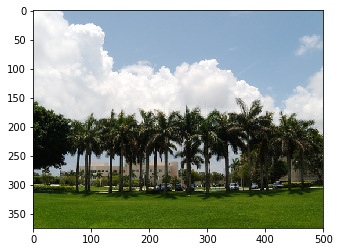

In [16]:
from matplotlib import pyplot as plt
plt.imshow(load_img(files[6]))

In [38]:
model = gen_model(img_size=128)
#model.load_weights('weights/mobilenet_model_v2.h5')
model.load_weights('model_weights/color_model_large.h5')

Model built and compiled


In [60]:
VAL_IMAGE_PATH = r"../dd2424_project/tiny-imagenet-200/train/n01443537/images"
batch_size = 10
image_size = 128

X = []
files = glob.glob(VAL_IMAGE_PATH+'/*')
files = files[:10]

In [61]:
files

['../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_406.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_215.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_467.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_457.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_115.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_5.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_452.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_227.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_303.JPEG',
 '../dd2424_project/tiny-imagenet-200/train/n01443537/images/n01443537_220.JPEG']